# Point Cloud Volume Estimation
Using the pre-computed depth of an input image, we will estimate the volume of a predetermined object of interest.

<IPython.core.display.Javascript object>


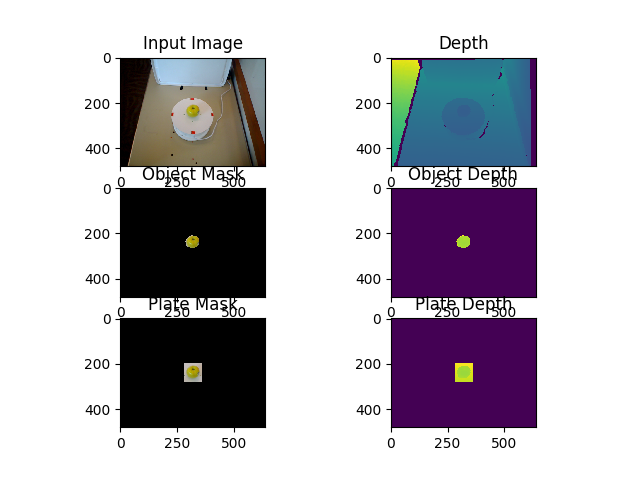

In [5]:
import numpy as np
import pandas as pd
import cv2
import keras.backend as K
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
from inference.project import *
from inference.point_cloud_utils import *

# Inputs (https://rgbd-dataset.cs.washington.edu/index.html)
input_img = cv2.imread('custom/apple_2.png', cv2.IMREAD_COLOR)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) / 255
depth = cv2.imread('custom/apple_2_depth.png', cv2.IMREAD_UNCHANGED) / 1000
object_mask = cv2.imread('custom/apple_2_mask.png', cv2.IMREAD_GRAYSCALE) / 255
plate_mask = cv2.imread('custom/apple_2_plate_mask.png', cv2.IMREAD_GRAYSCALE) / 255
# Create object and plate images/depth maps
object_colors = np.tile(np.expand_dims(object_mask, axis=-1), (1,1,3)) * input_img
object_depth = object_mask * depth
plate_colors = np.tile(np.expand_dims(plate_mask, axis=-1), (1,1,3)) * input_img
plate_depth = plate_mask * depth

%matplotlib notebook
pretty_plotting([input_img, depth, object_colors, object_depth, plate_colors, plate_depth],
                (3,2), ['Input Image', 'Depth', 'Object Mask', 'Object Depth', 'Plate Mask', 'Plate Depth'])
plt.show()

Apply object/plate mask and convert the input color and depth images to point clouds.

In [6]:
# Intrinsics
intrinsics = np.array([[570.3, 0, 320], [0, 570.3, 240], [0, 0, 1]])
intrinsics_inv = np.linalg.inv(intrinsics)
# Depth map to point cloud
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
xyz_points = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))
xyz_points_flat = np.reshape(xyz_points, (xyz_points.shape[1] * xyz_points.shape[2], 3))
# Get object and plate points by masking and ignoring with depth == 0
object_filter = np.reshape(object_depth, (object_depth.shape[0] * object_depth.shape[1])) > 0
plate_filter = np.reshape(plate_depth, (plate_depth.shape[0] * plate_depth.shape[1])) > 0
object_points = xyz_points_flat[object_filter, :]
plate_points = xyz_points_flat[plate_filter, :]

# Create point clouds (for plotting purposes)
colors_flat = np.reshape(input_img, (input_img.shape[0] * input_img.shape[1], 3))
object_colors_flat = colors_flat[object_filter, :] * 255
plate_colors_flat = colors_flat[plate_filter, :] * 255
object_points_df = pd.DataFrame(np.concatenate((object_points, object_colors_flat), axis=-1),
                                columns=['x','y','z','red','green','blue'])
plate_points_df = pd.DataFrame(np.concatenate((plate_points, plate_colors_flat), axis=-1),
                               columns=['x','y','z','red','green','blue'])
object_pc = PyntCloud(object_points_df)
plate_pc = PyntCloud(plate_points_df)

scene = object_pc.plot(initial_point_size=0.001, return_scene=True)
plate_pc.plot(initial_point_size=0.001, scene=scene)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.0006168041863468294, 0.024233484304763738…

Using the RANSAC algorithm, estimate the plate plane parameters. Filter outlier points in the object point cloud using a Statistical Outlier Removal filter.

In [7]:
plane_params = ransac_plane_estimation(plate_points, k=10)
object_points_filtered = sor_filter(object_points, z_max=1, inlier_ratio=0.5)
print('Estimated plane parameters (w0,w1,w2,w3):', plane_params)

# Create estimated plane point cloud
plane_z = np.apply_along_axis(lambda x: ((plane_params[0] + plane_params[1] * x[0]
                                          + plane_params[2] * x[1]) * (-1) / plane_params[3]),
                              axis=1, arr=plate_points[:,:2])
plane_points = np.concatenate((plate_points[:,:2], np.expand_dims(plane_z, axis=-1)), axis=-1)
# Plot filtered object point cloud and plane
object_points_filtered_df = pd.DataFrame(object_points_filtered, columns=['x','y','z'])
plane_points_df = pd.DataFrame(plane_points, columns=['x','y','z'])
object_filtered_pc = PyntCloud(object_points_filtered_df)
plane_pc = PyntCloud(plane_points_df)

scene = object_filtered_pc.plot(initial_point_size=0.001, use_as_color='z', return_scene=True)
plane_pc.plot(initial_point_size=0.005, use_as_color='z', cmap='cool', scene=scene)

Estimated plane parameters (w0,w1,w2,w3): [0.8346862196922302, 0.026761168614029884, -0.6356833577156067, -1]


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.0002214522974099964, 0.025004356168210506,…

/home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Transform object and plane points, matching the plate plane the xy-plane. Estimate total volume by triangulating the object on the xy plane and computing each triangle volume separately using as height its mean z value. 

Total Volume: 0.2957803655954678 L


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.0015996672797291992, -0.035711522459259494…

<IPython.core.display.Javascript object>


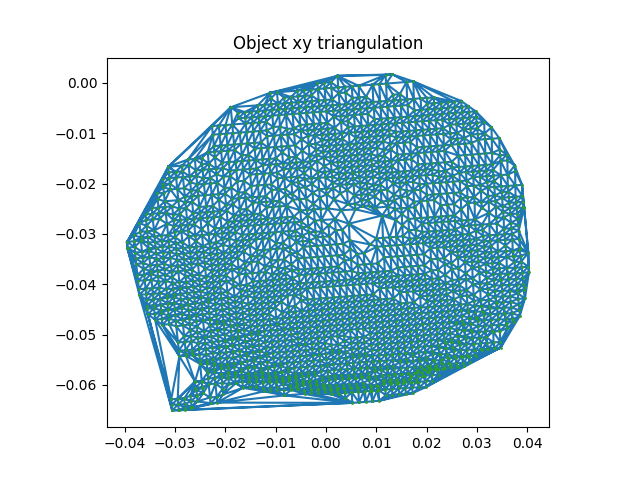

In [8]:
# Transform object and plane points
translation, rotation_matrix = align_plane_with_axis(plane_params, np.array([0,0,1]))
object_points_transformed = np.dot(object_points_filtered + translation, rotation_matrix.T)
plane_points_transformed = np.dot(plane_points + translation, rotation_matrix.T)
# Calculate volume
total_volume, simplices = estimate_volume(object_points_transformed)
print('Total Volume:', total_volume * 1000, 'L')

# Plot point clouds of transformed object and plane
object_points_transformed_df = pd.DataFrame(object_points_transformed, columns=['x','y','z'])
plane_points_transformed_df = pd.DataFrame(plane_points_transformed, columns=['x','y','z'])
plane_transformed_pc = PyntCloud(plane_points_transformed_df)
object_transformed_pc = PyntCloud(object_points_transformed_df)

scene = object_transformed_pc.plot(initial_point_size=0.001, use_as_color='z', return_scene=True)
plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

# Plot xy plane triangulation
%matplotlib notebook
plt.figure()
plt.triplot(object_points_transformed[:,0], object_points_transformed[:,1], simplices)
plt.plot(object_points_transformed[:,0], object_points_transformed[:,1], 'o', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Object xy triangulation')
plt.show()